In [1]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

from pymc3.gp.util import plot_gp_dist

In [2]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

# Utility models

In [3]:
def u_pow(x, theta): return x**theta

In [4]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

# Generate choice data

In [5]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=(0.5, )):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [6]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [7]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [8]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [9]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

In [55]:
u_data = u_pow
theta_data = (0.5, )
tau_data = 3.333
u_model = u_pow
theta_model = (0.5, )
tau_model = 3.333

In [56]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=100, seed=123)

In [57]:
p0 = data.p0.values
p1 = data.p1.values
x0 = data.x0.values
x1 = data.x1.values
y = data.choices.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))
x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
undo_sorted = np.argsort(x_order)

# compute M(x)
X = jnp.array(x_sorted)
uX = jnp.array(u_model(x_sorted, theta_model))

P_sorted = jnp.array(p_sorted)

Y = jnp.array(y)
n = Y.shape[0]

In [58]:
optimize(data, u_m=u_pow)

array([2.70539877, 0.25631151])

In [59]:
def exp_cov(X, Y, var, length, jitter=1.0e-6):
    deltaXsq = jnp.power(X[:, None] - Y, 2.0)
    k = var**2.0 * jnp.exp(-0.5 / length**2.0 * deltaXsq)
    k += jitter * jnp.eye(X.shape[0])
    return k


def model():
    
    var = numpyro.sample('kernel_var', dist.HalfCauchy(5))
    length = numpyro.sample('kernel_length', dist.InverseGamma(2, 2))
    
    # compute kernel
    k = exp_cov(X, X, var, length)
    ck = jax.scipy.linalg.cholesky(k, lower=True)
    
    # sample Y according to the standard gaussian process formula
    # f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, covariance_matrix=k))
    f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, scale_tril=ck))
    
    est_eu =  P_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    diff_eu_hat = est_eu_unsorted[n:] - est_eu_unsorted[:n]

    est_p_choice1 = numpyro.distributions.transforms.expit(tau_model * diff_eu_hat)
    
    choose_1 = numpyro.sample("choose_1", dist.Bernoulli(est_p_choice1), obs=Y)

In [60]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1, thinning=1)

In [61]:
mcmc.run(random.PRNGKey(0))

sample: 100%|██████████| 2000/2000 [36:18<00:00,  1.09s/it, 1023 steps of size 7.27e-08. acc. prob=0.75]


In [62]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           f[0]      0.69      0.00      0.69      0.69      0.69      0.50      1.00
           f[1]      1.33      0.00      1.33      1.33      1.33      0.50      1.00
           f[2]     -0.19      0.00     -0.19     -0.19     -0.19      0.50      1.00
           f[3]      1.74      0.00      1.74      1.74      1.74      0.50      1.00
           f[4]     -1.55      0.00     -1.55     -1.55     -1.55      0.50      1.00
           f[5]      1.70      0.00      1.70      1.70      1.70      0.50      1.00
           f[6]      1.25      0.00      1.25      1.25      1.25      0.50      1.00
           f[7]     -0.67      0.00     -0.67     -0.67     -0.67      0.50      1.00
           f[8]      1.78      0.00      1.78      1.78      1.78      0.50      1.00
           f[9]     -0.64      0.00     -0.64     -0.64     -0.64      0.50      1.00
          f[10]      1.04      0.00      1.04      1.

In [63]:
samples = np.asarray(mcmc.get_samples()['f'])

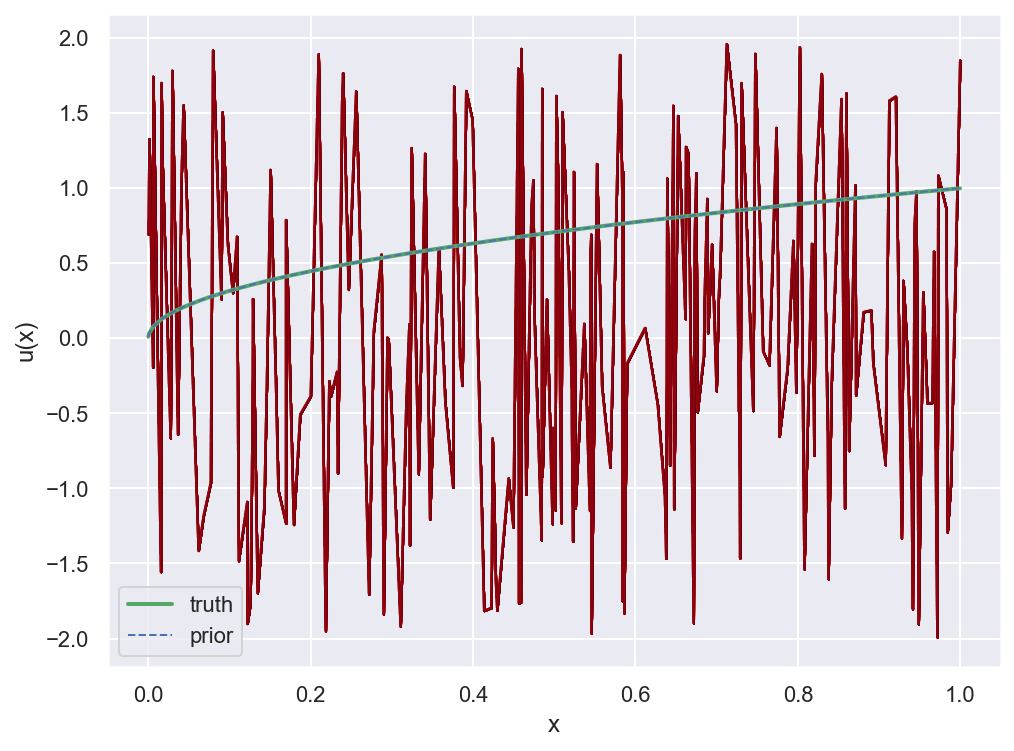

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_gp_dist(ax, samples, x_sorted)
ax.plot(x_sorted, u_data(x_sorted, theta_data), lw=2, color='C2', label="truth")
ax.plot(x_sorted, u_model(x_sorted, theta_model), lw=1, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();

## Sparse version

In [67]:
def exp_cov(X, Y, var, length, jitter=1.0e-6):
    deltaXsq = jnp.power(X[:, None] - Y, 2.0)
    k = var**2.0 * jnp.exp(-0.5 / length**2.0 * deltaXsq)
    k += jitter * jnp.eye(X.shape[0])
    return k


def model():
    
    var = numpyro.sample('kernel_var', dist.HalfCauchy(5))
    length = numpyro.sample('kernel_length', dist.InverseGamma(2, 2))
    
    # compute kernel
    k = exp_cov(X, X, var, length)
    ck = jax.scipy.linalg.cholesky(k, lower=True)
    
    # sample Y according to the standard gaussian process formula
    # f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, covariance_matrix=k))
    f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, scale_tril=k))
    
    est_eu =  P_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    diff_eu_hat = est_eu_unsorted[n:] - est_eu_unsorted[:n]

    est_p_choice1 = numpyro.distributions.transforms.expit(tau_model * diff_eu_hat)
    
    choose_1 = numpyro.sample("choose_1", dist.Bernoulli(est_p_choice1), obs=y)

In [68]:
def u_lin(x, theta): return x

u_data = u_pow
theta_data = (0.5, )
tau_data = 3.333

u_model = u_lin
theta_model = (None, )
tau_model = 3.333

In [69]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000)

In [79]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, thinning=1, num_chains=2,
           chain_method='sequential')

In [80]:
max_n = 100
if len(data) > max_n:
    np.random.seed(12345)
    data_gp = data.sample(n=max_n, replace=False)
else:
    data_gp = data

mcmc.run(random.PRNGKey(0), data=data_gp, theta=theta_model, tau=tau_model, u_m=u_model)

sample: 100%|██████████| 2000/2000 [01:44<00:00, 19.07it/s, 255 steps of size 6.31e-02. acc. prob=0.51]


In [81]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           f[0]      0.02      0.05      0.01     -0.05      0.09   1208.34      1.01
           f[1]      0.03      0.07      0.02     -0.07      0.15    325.25      1.01
           f[2]      0.05      0.09      0.04     -0.07      0.19    117.18      1.02
           f[3]      0.06      0.10      0.05     -0.08      0.20     60.68      1.03
           f[4]      0.08      0.11      0.06     -0.07      0.25     28.32      1.04
           f[5]      0.09      0.12      0.06     -0.08      0.29     18.43      1.05
           f[6]      0.10      0.12      0.07     -0.08      0.31     17.47      1.05
           f[7]      0.11      0.13      0.08     -0.07      0.33     15.78      1.06
           f[8]      0.12      0.14      0.09     -0.08      0.34     13.01      1.07
           f[9]      0.13      0.14      0.10     -0.09      0.36     11.80      1.07
          f[10]      0.14      0.15      0.11     -0.

In [82]:
samples = np.asarray(mcmc.get_samples()['f'])

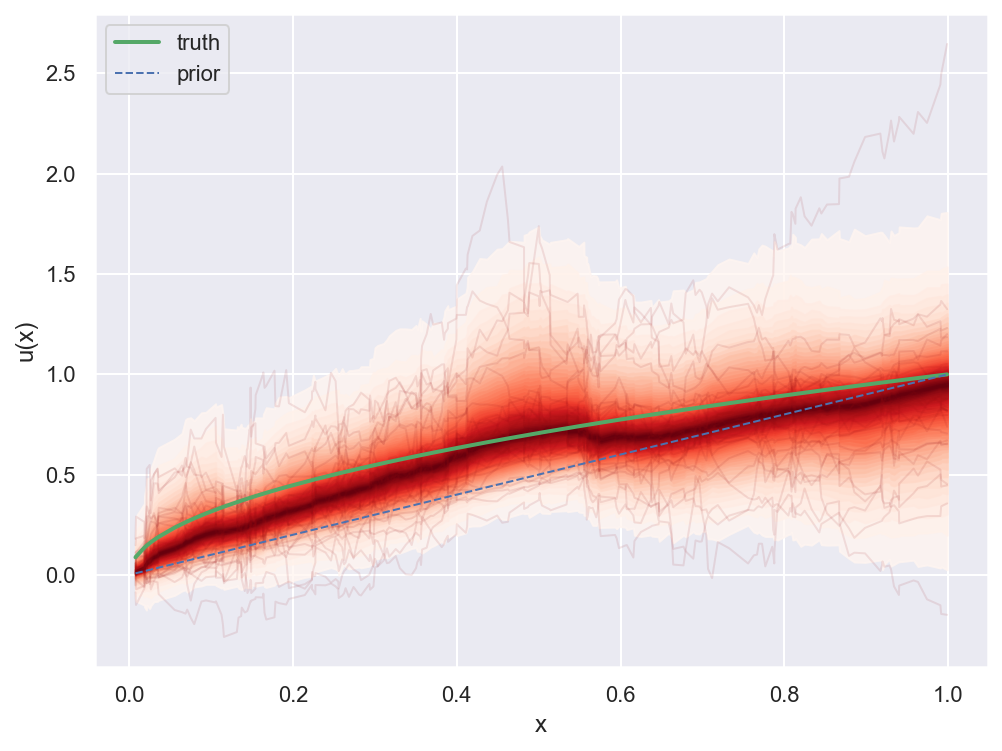

In [83]:
x0 = data_gp.x0.values
x1 = data_gp.x1.values
y = data_gp.choices.values

x = np.hstack((x0, x1))
x_sorted = x[np.argsort(x)]

fig, ax = plt.subplots(figsize=(8, 6))
plot_gp_dist(ax, samples, x_sorted)
ax.plot(x_sorted, u_data(x_sorted, theta_data), lw=2, color='C2', label="truth")
ax.plot(x_sorted, u_model(x_sorted, theta_model), lw=1, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();